In [1]:
import pandas as pd
import numpy as np
import os
import sys
import json
import requests
import gc
from tqdm import tqdm

from google.cloud import bigquery
from google.cloud.bigquery import job
from datetime import date, timedelta

PROJCECT = 'ballosodeuk'
bq = bigquery.Client(project=PROJCECT)

#  클라이언트 설정



In [80]:
query = """
with raw as 
  (
    select 
      order_dt, order_no, member_no
      ,sum(first_pay_amt) as first_pay_amt, sum(first_sub_pay_amt) as first_sub_pay_amt
  from
    (
      select 
        order_dt, order_no, member_no, first_pay_amt, first_sub_pay_amt
      from ballosodeuk.dw.fact_shopby_order, unnest(product_option)
      where 1=1
        and length(claim_status_type) < 1
        and date(order_dttm) > "2024-12-30")
    group by order_dt, order_no, member_no
  )

,merge_raw as (
  select 
    user_id, 
    order_dt,
    sum(first_pay_amt) as first_pay_amt, 
    sum(first_sub_pay_amt) as first_sub_pay_amt
  from (
    select b.wk_id as user_id, a.*
    from raw a
    left join ballosodeuk.dw.dim_shopby_member b on a.member_no = b.member_no
  )
  group by user_id, order_dt
)

,daily_net_amount as 
    (select 
        register_dt, member_no, sum(coalesce(earn,0) - coalesce(cancel,0)) as num
    from
        (SELECT 
            register_dt, member_no,
                CASE WHEN accumulation_status IN ('취소로 인한 지급','지급') THEN amt END as earn,
                CASE WHEN accumulation_status IN ('차감') THEN amt END as cancel
        FROM ballosodeuk.dw.fact_shopby_reward)
    group by register_dt, member_no)

,exception_case as (
  select register_dt, user_id, sum(amt) as amt, "소멸" as reason
  from 
    (select register_dt, a.member_no, wk_id as user_id, amt, reason
    from ballosodeuk.dw.fact_shopby_reward a
    inner join ballosodeuk.dw.dim_shopby_member b on a.member_no = b.member_no
    where reason ="유효기간 만료")
  group by register_dt, user_id
)

,exception_case_2 as (
  select register_dt, user_id, sum(amt) as amt, "교환권" as reason
  from
    (select register_dt, a.member_no, wk_id as user_id, amt
    from ballosodeuk.dw.fact_shopby_reward a
    inner join ballosodeuk.dw.dim_shopby_member b on a.member_no = b.member_no
    where 1=1
      and reason = "운영자 지급" 
      and reason_detail like "%교환%" or reason_detail in("쇼핑지원금 상품권 적립","쇼핑지원금 교환권 적립","쇼핑지원금 환전","쇼핑지원금 5,000원 교환 쿠폰","쇼핑지원금 전환"))
  group by register_dt, user_id
)

,cumulative_amount as (
    select register_dt, member_no, num as daily_net_amount,
        sum(num) over (
            partition by member_no
            order by register_dt
            rows between unbounded preceding and current row
        ) as cummulative_amount
    from daily_net_amount
)

,merged_ as 
    (select b.wk_id as user_id, a.* except(member_no)
    from cumulative_amount a
    inner join ballosodeuk.dw.dim_shopby_member b on a.member_no = b.member_no
    order by user_id, register_dt
    )

,merged as 
  (select register_dt, user_id, 
    lag(cummulative_amount) over (partition by user_id order by register_dt asc) as pre_shoji,
    cummulative_amount as current_shoji,
    lead(cummulative_amount,1) over (partition by user_id order by register_dt asc) as post_shoji_1,
    lead(cummulative_amount,2) over (partition by user_id order by register_dt asc) as post_shoji_2,
    lead(cummulative_amount,3) over (partition by user_id order by register_dt asc) as post_shoji_3,
    lead(cummulative_amount,4) over (partition by user_id order by register_dt asc) as post_shoji_4,
    lead(cummulative_amount,5) over (partition by user_id order by register_dt asc) as post_shoji_5,
    lead(cummulative_amount,6) over (partition by user_id order by register_dt asc) as post_shoji_6,
    lead(cummulative_amount,7) over (partition by user_id order by register_dt asc) as post_shoji_7,
    lead(cummulative_amount,8) over (partition by user_id order by register_dt asc) as post_shoji_8,
    lead(cummulative_amount,9) over (partition by user_id order by register_dt asc) as post_shoji_9,
    lead(cummulative_amount,10) over (partition by user_id order by register_dt asc) as post_shoji_10,
    lead(cummulative_amount,11) over (partition by user_id order by register_dt asc) as post_shoji_11,
    lead(cummulative_amount,12) over (partition by user_id order by register_dt asc) as post_shoji_12,
    lead(cummulative_amount,13) over (partition by user_id order by register_dt asc) as post_shoji_13
    
  from merged_ )

,df as 
  (select 
    a.register_dt, a.user_id, pre_shoji, current_shoji
    ,post_shoji_1, post_shoji_2, post_shoji_3, post_shoji_4, post_shoji_5, post_shoji_6, post_shoji_7, post_shoji_8, post_shoji_9, post_shoji_10, post_shoji_11, post_shoji_12, post_shoji_13
    ,first_pay_amt, first_sub_pay_amt, c.amt as burnt, d.amt as exchange,
    round(first_sub_pay_amt / first_pay_amt,2) as sub_power
  from merged a
  inner join merge_raw b on a.user_id = b.user_id and a.register_dt = b.order_dt
  left join exception_case c on c.user_id = a.user_id and a.register_dt = c.register_dt
  left join exception_case_2 d on d.user_id = a.user_id and a.register_dt = d.register_dt)


select * from df
"""

In [81]:

df = bq.query(query).to_dataframe()
df = df.query("user_id.notnull()")
df.iloc[:,-1] = df.iloc[:,-1].fillna(0).astype(int)
df['register_dt'] = pd.to_datetime(df.register_dt.astype(str))

c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\google\cloud\bigquery\table.py:2309: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\google\cloud\bigquery\table.py:2323: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\google\cloud\bigquery\table.py:2337: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
<ipython-input-81-a6950ebfcb43>:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attem

In [82]:
df.fillna(0, inplace=True)
df.head()


,register_dt,user_id,pre_shoji,current_shoji,post_shoji_1,post_shoji_2,post_shoji_3,post_shoji_4,post_shoji_5,post_shoji_6,...,post_shoji_9,post_shoji_10,post_shoji_11,post_shoji_12,post_shoji_13,first_pay_amt,first_sub_pay_amt,burnt,exchange,sub_power
0,2024-12-31,01972243-698b-4345-9cad-c6beb8a343cc,0,29,145,201,373,461,499,778,...,1097,1126,1258,1346,1428,89700,4485,0,0,0
1,2024-12-31,18f47005-002c-4146-af89-dd1520144486,26282,2,47,63,218,237,352,374,...,541,623,747,757,774,27400,26306,0,0,0
2,2024-12-31,73d29bd2-6458-4350-b9ca-827ab746c9b2,19800,960,976,1070,1086,1097,1489,1505,...,1658,1674,1678,1832,1848,18900,18900,0,0,1
3,2024-12-31,a0287465-63c6-4712-a61b-5b286aa328a5,20167,0,17,133,170,430,468,506,...,766,795,987,1016,1044,23500,20271,0,0,0
4,2024-12-31,b37453e6-3bb9-40e2-8ac0-7ede4a4ce7ed,3,55,164,327,427,478,0,0,...,0,0,0,0,0,75000,3750,0,0,0


In [13]:
df.info()
df.exchange.value_counts()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7610 entries, 0 to 7609
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   register_dt           7610 non-null   datetime64[ns]
 1   user_id               7610 non-null   object        
 2   pre_shoji             7610 non-null   Int64         
 3   current_shoji         7610 non-null   Int64         
 4   post_shoji            7610 non-null   Int64         
 5   first_pay_amt         7610 non-null   Int64         
 6   first_sub_pay_amt     7610 non-null   Int64         
 7   burnt                 7610 non-null   Int64         
 8   exchange              7610 non-null   Int64         
 9   sub_power             7610 non-null   float64       
 10  left_behind_multiple  7610 non-null   int32         
dtypes: Int64(7), datetime64[ns](1), float64(1), int32(1), object(1)
memory usage: 735.7+ KB


0        6280
100       827
300       259
500       125
1000       47
5000       30
3000       26
10000      11
5100        4
5300        1
Name: exchange, dtype: Int64

In [20]:
## 교환권 구매 유저 중, 교환권 구매 후 1000원 이하로 남은 유저 비율
df[(df.post_shoji < 1000) & (df.exchange > 0)].user_id.nunique() / df[df.exchange > 0].user_id.nunique()

0.8014411529223379

In [39]:
# current - post 차이는 26원 수준. 20일의 post는 current 로 보간 가능.
print(
    (df.query("register_dt < '2025-01-20'").current_shoji - df.query("register_dt < '2025-01-20'").post_shoji).mean()
    )


26.198410523431075

In [42]:
df.loc[df['register_dt'] == '2025-01-20', 'post_shoji'] = df.loc[df['register_dt'] == '2025-01-20', 'current_shoji']
df['using_power'] = df['first_sub_pay_amt'] / (df['post_shoji'] + df['first_sub_pay_amt'])
df

,register_dt,user_id,pre_shoji,current_shoji,post_shoji,first_pay_amt,first_sub_pay_amt,burnt,exchange,sub_power,left_behind_multiple,using_power
0,2024-12-31,3ac5085b-52db-48b7-8eda-b79059dd2266,3665,6,21,3900,3800,0,0,0.97,0,0.994504
1,2024-12-31,93a3c943-3bc3-4219-b2bb-f9995a919de0,0,6,14,38800,26,0,0,0.00,0,0.65
2,2024-12-31,b828cfe8-8deb-44fe-aa6b-a0a832e0dbc9,10,228,246,39700,1985,0,0,0.05,0,0.889736
3,2024-12-31,dc774d9a-71d5-4dc1-b0a2-c811ccb2ef2c,7037,6,18,15300,7049,0,0,0.46,0,0.997453
4,2024-12-31,08f34b4e-414a-44e8-aac9-e786e7f0ebf8,8250,224,242,8100,8100,0,0,1.00,0,0.97099
...,...,...,...,...,...,...,...,...,...,...,...,...
7605,2025-01-20,38d64377-54d0-4029-9009-71413032b3bd,50050,18753,18753,31300,31300,0,0,1.00,0,0.625337
7606,2025-01-20,582f1a7c-dfa9-4ed6-ac29-4ba3c19f9344,2165,2180,2180,11500,575,0,0,0.05,0,0.208711
7607,2025-01-20,64319710-b17e-4fd0-bf37-92f1beef34bf,2586,101,101,9900,2500,0,0,0.25,0,0.961169
7608,2025-01-20,84124727-e2db-4298-8fdb-0b607fd25b82,12750,29,29,27900,12750,0,0,0.46,0,0.997731


In [55]:
## 쇼핑지원금 사용 강도의 통계
df.using_power = df.using_power.replace('<NA>', np.nan)
df.using_power = df.using_power.astype(float)
df.using_power.isnull().sum()
df.using_power.fillna(0,inplace=True)

df.using_power.mean(), df.using_power.std()

(0.8163404339768151, 0.24498839991113336)

<ipython-input-60-8770b8200f64>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
<ipython-input-60-8770b8200f64>:25: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')
<ipython-input-60-8770b8200f64>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.set_xticklabels(plt.get_xticklabels(), rotation=45, ha='right')


Text(0.5, 1.0, '쇼핑지원금 사용 강도 분포')

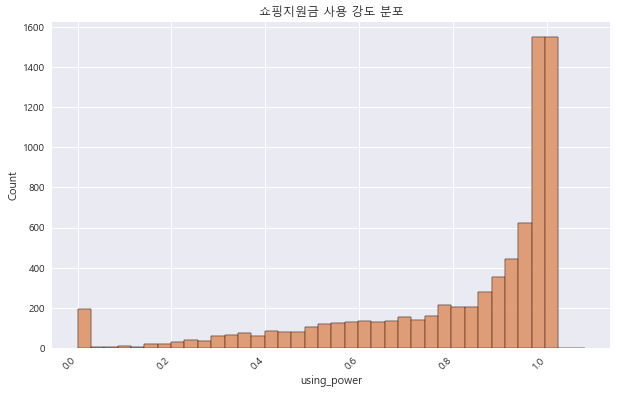

In [60]:
# 유저는 구매 시, 소지한 쇼핑지원금을 모두 사용하는 경향이 있다.
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
# 한글 폰트 설정
import matplotlib.font_manager as fm

# 폰트 경로 확인 및 설정
font_path = 'C:/Windows/Fonts/malgun.ttf'  # Malgun Gothic 폰트 경로
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rcParams['font.family'] = font_name
plt.rcParams['axes.unicode_minus'] = False

# 그래프 생성
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(data=df.using_power, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_title('쇼핑지원금 사용 강도 분포', fontsize=12, pad=15)

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 깨짐 방지

# 그래프 스타일 설정 
plt.style.use('seaborn')
sns.set_palette('Set2')

plt = sns.histplot(df.using_power)
plt.set_xticklabels(plt.get_xticklabels(), rotation=45, ha='right')
plt.set_title('쇼핑지원금 사용 강도 분포', fontsize=12)


In [72]:
len(df[df['using_power']> 0.95]) / len(df)

0.4624178712220762

In [74]:
df.sort_values(by=['user_id','register_dt'], ascending=False).head(10)

,register_dt,user_id,pre_shoji,current_shoji,post_shoji,first_pay_amt,first_sub_pay_amt,burnt,exchange,sub_power,left_behind_multiple,using_power
573,2024-12-31,fffe2372-15bd-48ec-9022-a807c1a94080,10020,116,131,11800,10055,0,100,0.85,0,0.987139
2253,2025-01-04,fffa6faf-ce57-4bf7-9bc7-d881138c3db6,566,3,7,9900,1096,0,100,0.11,0,0.993654
1374,2025-01-02,ffe92eba-4186-4072-8c0a-8feac6c50fcf,3450,1,2,8900,3450,0,0,0.39,0,0.999421
6733,2025-01-18,ffd3247a-99f0-4eb2-9521-6979b3536f17,6442,3,322,9900,6873,0,300,0.69,0,0.955247
4421,2025-01-10,ffd16b86-6df9-433b-9a8b-19e1760e4c50,5210,0,3,7800,5210,0,0,0.67,0,0.999425
7274,2025-01-19,ffc7c9f5-b3d5-4b7a-b300-4b197258975e,16881,0,0,22800,16881,0,0,0.74,0,1.000000
2365,2025-01-04,ffc5f65a-d10f-41e7-8873-93a17c218f2d,35690,12758,12819,23000,23000,0,0,1.00,0,0.642117
367,2024-12-31,ffc5f65a-d10f-41e7-8873-93a17c218f2d,49000,35529,35627,13500,13500,0,0,1.00,2,0.274798
4632,2025-01-11,ffbf9f14-b561-45a8-b083-42cc67e4971a,3594,3,6,9900,3594,0,0,0.36,0,0.998333
1213,2025-01-02,ffb76d44-cb13-4c72-ba25-dc722b1df5b4,0,15,15,13500,675,0,0,0.05,0,0.978261


In [103]:
tst = df[df['register_dt'] < "2025-01-15" ][['register_dt','user_id','burnt', 'exchange','post_shoji_1','post_shoji_6','post_shoji_13']]
tst['tst'] = tst['post_shoji_6'] > tst['post_shoji_1']


In [104]:
tst.groupby('tst').user_id.count()

tst
False    1467
True     4311
Name: user_id, dtype: int64

In [124]:
tst.groupby('user_id').user_id.count().sort_values(ascending=False).head(100)
tst.query("user_id == 'f732be14-bde6-4833-9643-82144089b223'")

,register_dt,user_id,burnt,exchange,post_shoji_1,post_shoji_6,post_shoji_13,tst
1249,2025-01-02,f732be14-bde6-4833-9643-82144089b223,0,0,43,303,0,True
2175,2025-01-04,f732be14-bde6-4833-9643-82144089b223,0,0,283,0,0,False
3060,2025-01-06,f732be14-bde6-4833-9643-82144089b223,0,0,303,0,0,False
4273,2025-01-10,f732be14-bde6-4833-9643-82144089b223,0,0,303,0,0,False
4533,2025-01-11,f732be14-bde6-4833-9643-82144089b223,4375,0,312,0,0,False


In [128]:

exchange = tst[tst['exchange'] > 0]
exchange.sort_values('register_dt').drop_duplicates(subset=['user_id'], keep='last', inplace=True)
exchange.groupby('tst').user_id.count()


tst
False    174
True     708
Name: user_id, dtype: int64

In [133]:
burnt = tst[tst['burnt'] > 0]
burnt.sort_values('register_dt').drop_duplicates(subset=['user_id'], keep='last', inplace=True)
burnt.groupby('tst').user_id.count()
burnt

,register_dt,user_id,burnt,exchange,post_shoji_1,post_shoji_6,post_shoji_13,tst
82,2024-12-31,14db65e0-ecc4-41c8-87da-92f4232571bf,545,0,31,447,732,True
549,2024-12-31,a518bd7c-d523-477d-92a5-f5728be7c9a3,1140,0,318,375,0,True
660,2025-01-01,fa197d92-efc0-42e6-9cfa-b581994d7d50,346,0,111,210,381,True
670,2025-01-01,4f0f9588-48a3-4901-8d9c-ff8dac703878,2717,0,9326,9740,414,True
1334,2025-01-02,17e215c4-107f-48c5-a8a8-1fa2a2eda680,3000,0,23,317,724,True
1467,2025-01-02,9ba560e0-f69b-4068-a9f5-ea201212a992,675,0,497,106,597,False
1564,2025-01-02,601b123a-ea4f-4358-9aef-f8f95354b908,4023,0,1443,1576,2093,True
1596,2025-01-02,0f45608d-59bb-464d-81ce-358f2300508b,385,0,29,72,160,True
1759,2025-01-03,d428c207-0b61-41a1-8601-faafb787f61e,1140,100,1401,2143,3512,True
1774,2025-01-03,02767d59-5cc0-45ad-8842-0c5fda82a361,675,0,693,999,1410,True
